# Simulate scRNA-seq data under the framework of Splatter

In [3]:
import sys
sys.path.append('../scripts')

In [4]:
import pandas as pd
import numpy as np
from gepsim import gepsim

In [5]:
ngenes = 2000
ncells = 3000
K = 4
seed = 29975
deloc = 1.0
zidecay = 0.30
zinf = True

In [6]:
simulator = gepsim(ngenes=ngenes, ncells=ncells, ngroups=K, libloc=7.64, libscale=0.78,
                   mean_rate=7.68, mean_shape=0.34, expoutprob=0,
                   expoutloc=6.15, expoutscale=0.49,
                   diffexploc=deloc, diffexpscale=1.0,
                   bcv_dispersion=0.448, bcv_dof=22.087,
                   seed=seed, zeroinflate=zinf, zidecay=zidecay)
simulator.simulate()

Simulating cells
Simulating gene params
Simulating DE
Simulating cell-gene means
   - Normalizing by cell libsize
Adjusting means
Simulating counts
Simulating zero inflated counts


In [7]:
counts = simulator.zicounts
celldata = simulator.cellparams
genedata = simulator.geneparams

# Create an AnnData object

In [8]:
import scanpy as sc

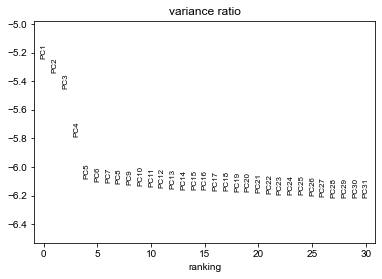

In [9]:
adata = sc.AnnData(counts, obs=celldata, var=genedata)
sc.pp.normalize_total(adata, target_sum=1.0)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata, log=True)

In [10]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
sc.tl.umap(adata)

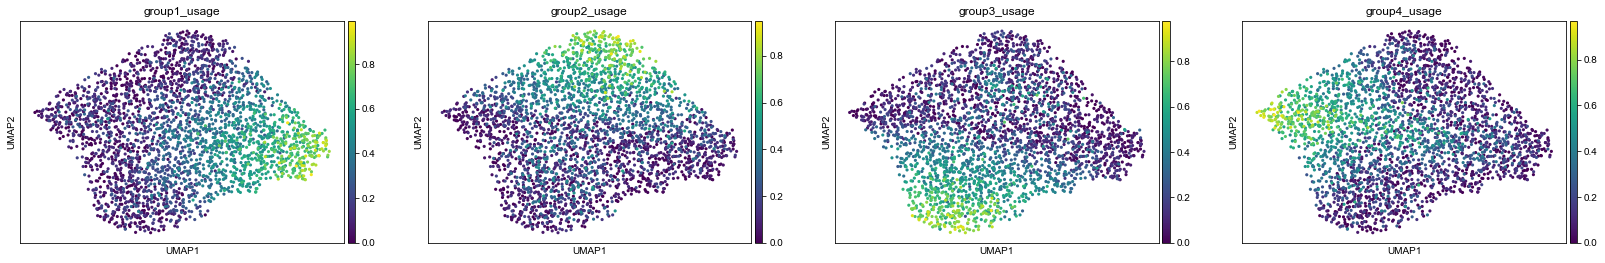

In [18]:
# UMAPs colored by true usage of each GEP
sc.pl.umap(adata, color=['group%d_usage' %i for i in range(1,5)])

# Run scAAnet on the original count data

In [11]:
from scAAnet.api import scAAnet

In [12]:
preds = scAAnet(counts, hidden_size=(128, 4, 128), ae_type='zipoisson',
                epochs=200, batch_size=64,
                early_stop=100, reduce_lr=10, learning_rate=0.01)

Training loss at epoch 0 (for the last batch): 1.5372
Learning rate is: 0.010000
<tf.Variable 'z_fixed:0' shape=(4, 3) dtype=float32, numpy=
array([[ 1.        ,  0.        ,  0.        ],
       [-0.33333334,  0.94280905,  0.        ],
       [-0.33333334, -0.47140452,  0.8164966 ],
       [-0.33333334, -0.47140452, -0.8164966 ]], dtype=float32)>
Training loss at epoch 50 (for the last batch): 1.0190
Learning rate is: 0.001250
<tf.Variable 'z_fixed:0' shape=(4, 3) dtype=float32, numpy=
array([[ 1.0488476 , -0.00346061, -0.00109764],
       [-0.35851672,  0.99433047, -0.0019429 ],
       [-0.35384536, -0.50062877,  0.863054  ],
       [-0.34441483, -0.4893833 , -0.8542698 ]], dtype=float32)>
Training loss at epoch 100 (for the last batch): 1.0678
Learning rate is: 0.001000
<tf.Variable 'z_fixed:0' shape=(4, 3) dtype=float32, numpy=
array([[ 1.0516192e+00, -4.2088483e-03, -1.2600182e-03],
       [-3.5791227e-01,  9.9839979e-01,  7.6883694e-04],
       [-3.5750303e-01, -5.0515491e-01,  8

In [13]:
recon, usage, spectra = preds['recon'], preds['usage'], preds['spectra']

In [14]:
usage = pd.DataFrame(usage, index=counts.index, columns = np.arange(1,K+1))
spectra = pd.DataFrame(np.transpose(spectra), index=counts.columns, columns=np.arange(1,K+1))
recon = pd.DataFrame(recon, index=counts.index, columns=counts.columns)

In [15]:
# Append inferred cell usage to the obs of adata
for i in range(1,5):
    adata.obs['Inferred usage %d' %i] = usage.iloc[:,i-1]

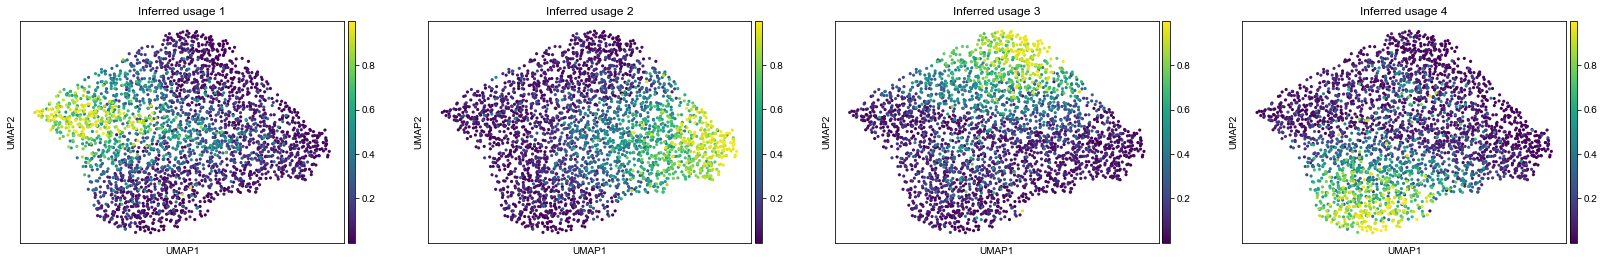

In [16]:
# UMAPs colored by inferred usage of each GEP
sc.pl.umap(adata, color=['Inferred usage %d' %i for i in range(1,5)])

# Look at top genes in each identified GEP

In [17]:
from scAAnet.tools import geneScore, plotDensityGamma

In [18]:
# Calculate normalized gene scores
gene_score = geneScore(spectra)

In [19]:
gene_score.head(20)

,1,2,3,4
Gene1,0.016495,0.030099,0.056209,0.020163
Gene2,0.018714,0.029273,0.055537,0.019827
Gene3,0.016703,0.030123,0.056181,0.020051
Gene4,0.016445,0.030116,0.056623,0.020144
Gene5,0.016452,0.030128,0.056250,0.020154
Gene6,0.016450,0.030129,0.056251,0.020155
Gene7,0.016171,0.030190,0.058914,0.020036
Gene8,0.016239,0.029095,0.054582,0.022153
Gene9,0.016446,0.030130,0.056251,0.020155
Gene10,0.016504,0.030460,0.055928,0.020171


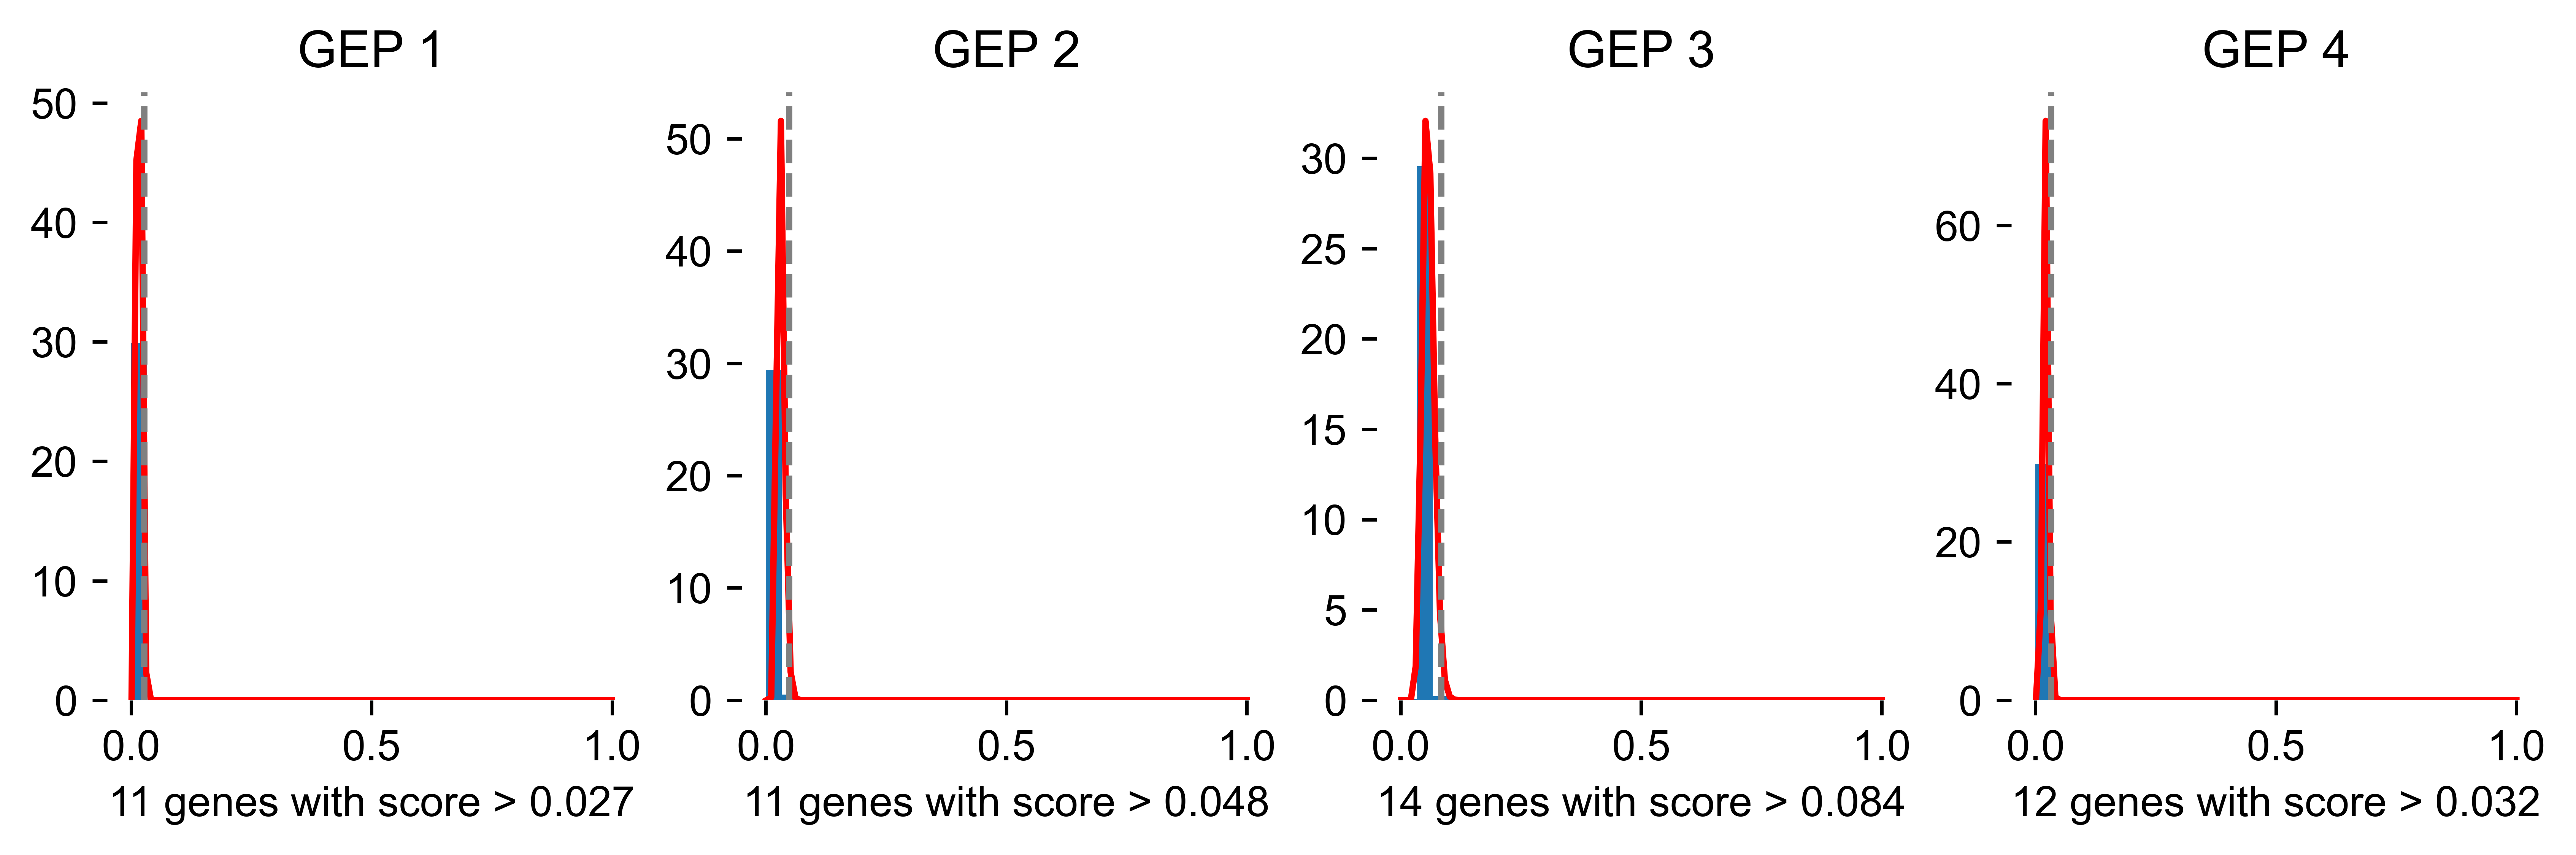

In [20]:
# Density plot of normalized gene scores fitted by Gamma distributions in each GEP
# add return top genes in each GEP whose normalized gene scores are larger than 
# a cutoff (default is the 0.975 probability threshold on the fitted Gamma distribution)
gep_top_genes = plotDensityGamma(gene_score, ncol=4)

# Run DEG tests to identify program-specific DEGs

In [21]:
from scAAnet.tools import programDEG

In [22]:
results = programDEG(counts, usage.to_numpy(), test_use='nb_naive', offset=True)

In [23]:
keys = list(results.keys())
for i in range(len(results)):
    re = results[keys[i]]
    re = re[re['coef.est']>0]
    print('%s:'%(keys[i]), np.sum(re['p.val.adj'] < 0.05))
    print(re.sort_values(by='p.val.adj').head(20))

gep_1: 59
          gene  coef.est          p.val    z.score      p.val.adj
1580  Gene1908  3.142402   0.000000e+00  45.868679   0.000000e+00
395    Gene489  2.662946  4.558880e-262  34.582950  7.581417e-259
613    Gene754  2.014389  2.256507e-143  25.494708  3.752571e-140
577    Gene711  2.144417  4.338119e-128  24.077154  7.214291e-125
168    Gene210  1.685118  1.080071e-123  23.653746  1.796158e-120
1624  Gene1956  1.716938   1.695481e-99  21.172965   2.819585e-96
166    Gene208  1.596237   7.063136e-96  20.776495   1.174600e-92
1398  Gene1689  2.882022   3.529332e-91  20.250321   5.869279e-88
574    Gene708  1.608890   5.504061e-84  19.417367   9.153254e-81
997   Gene1204  2.203119   2.500815e-81  19.100500   4.158856e-78
504    Gene623  1.466374   1.704961e-80  19.000015   2.835350e-77
756    Gene921  1.351828   1.096991e-72  18.031782   1.824296e-69
918   Gene1113  1.390080   9.255722e-72  17.913484   1.539227e-68
677    Gene836  1.831613   2.308199e-71  17.862557   3.838535e-68


In [24]:
genedata.sort_values('group4_DEratio', ascending=False).head(20)

,BaseGeneMean,is_outlier,outlier_ratio,gene_mean,group1_DEratio,group1_genemean,group2_DEratio,group2_genemean,group3_DEratio,group3_genemean,group4_DEratio,group4_genemean
Gene1908,0.298243,False,1,0.298243,1.000000,0.298243,1.000000,0.298243,1.000000,0.298243,30.227077,9.015
Gene489,0.0240438,False,1,0.0240438,1.000000,0.0240438,1.000000,0.0240438,1.000000,0.0240438,29.728289,0.714782
Gene1689,0.00273177,False,1,0.00273177,0.267822,0.000731629,1.000000,0.00273177,1.000000,0.00273177,20.980631,0.0573143
Gene514,0.00281138,False,1,0.00281138,1.000000,0.00281138,1.000000,0.00281138,1.000000,0.00281138,16.949098,0.0476503
Gene1504,3.30298e-05,False,1,3.30298e-05,0.685541,2.26433e-05,1.000000,3.30298e-05,1.000000,3.30298e-05,15.535365,0.00051313
Gene711,0.0223571,False,1,0.0223571,0.368773,0.00824469,1.000000,0.0223571,1.000000,0.0223571,10.647205,0.23804
Gene1204,0.00910025,False,1,0.00910025,1.000000,0.00910025,1.000000,0.00910025,1.000000,0.00910025,9.747510,0.0887048
Gene754,0.0593763,False,1,0.0593763,1.000000,0.0593763,1.000000,0.0593763,1.000000,0.0593763,7.640684,0.453675
Gene1794,0.00472546,False,1,0.00472546,1.000000,0.00472546,1.000000,0.00472546,1.000000,0.00472546,7.032979,0.033234
Gene708,0.0508429,False,1,0.0508429,1.000000,0.0508429,1.274985,0.0648239,1.000000,0.0508429,5.995029,0.304805
